In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.rcParams['figure.figsize'] = [8, 3] # Change default plot size
plt.rcParams['lines.linewidth'] = 1.0 # Change default line width
plt.rcParams.update({'font.size': 10}) # Change default font size

# Project 2. Enzyme kinetics and microbial growth

## Exercise 4

The following data (at steady-state) were obtained in a chemostat for the growth of *yeast* for biomass production:

<center>

| Dilution rate (h<sup>-1</sup>) | Cell concentration (g.L<sup>-1</sup>) | Carbon substrate concentration (g.L<sup>-1</sup>)|
|:-------:|:-------:|:--------:|
|  0.05   |  3.20   |  0.012   |
|  0.10   |  3.70   |  0.028   |
|  0.20   |  4.00   |  0.050   |
|  0.40   |  4.40   |  0.100   |
|  0.60   |  4.75   |  0.150   |
|  0.70   |  4.90   |  0.176   |
|  0.80   |  4.50   |  0.800   |
|  0.84   |  0.50   |  9.000   |

</center>

Note: substrate concentration in the feed is 10 g.L<sup>-1</sup> and an excess of oxygen was used.

In [81]:
D = np.array([0.05, 0.1, 0.2, 0.4, 0.6, 0.7, 0.8, 0.84]) # Dilution rate, 1/h
X = np.array([3.2, 3.7, 4, 4.4, 4.75, 4.9, 4.5, 0.5]) # Cell concentration, g/L
S = np.array([0.012, 0.028, 0.05, 0.1, 0.15, 0.176, 0.8, 9]) # Carbon substrate concentration, g/L
S0 = 10 # Carbon substrate concentration in the feed, g/L

**a) Estimate (assuming Monod kinetics) maximum growth rate $\mu_{max}$ and Saturation/Monod constant ($K_s$).**

In a chemostrat at steady-state, the specific growth rate $\mu$ is equal to the dilution rate $D$.

Assuming Monod kinetics:
* $D = \mu_{max}\frac{[S]}{K_S + [S]}$

Because the dilution rate $D$ and the substrate concentration $[S]$ is known, a Lineweaver-Burke plot can be plotted with $y = \frac{1}{D}$ and $x = \frac{1}{[S]}$, which gives:
* $\frac{1}{D} = \frac{K_S}{\mu_{max}}\frac{1}{[S]} + \frac{1}{\mu_{max}}$.

Linear regression gives $\frac{K_S}{\mu_{max}}$ for the slope and $\frac{1}{\mu_{max}}$ for the intercept with the y-axis. Intercept with the x-axis is $\frac{-1}{Ks}$.

μₘₐₓ = 0.96 h⁻¹
Kₛ = 0.11 g.L⁻¹



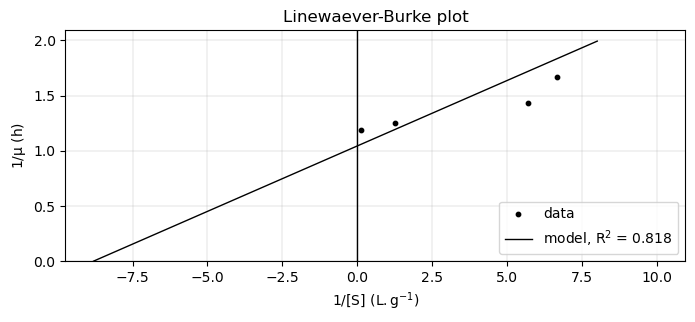

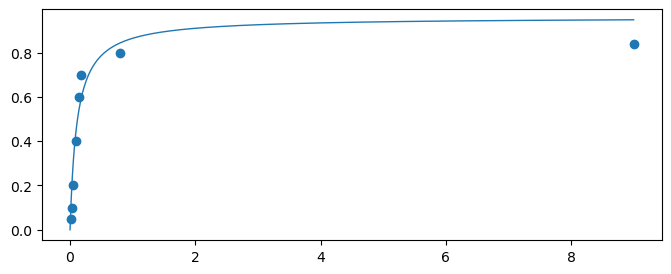

In [86]:
x = (1/S[4:]).reshape((-1, 1))
y = 1/D[4:]

model = LinearRegression().fit(x, y)
slope = model.coef_[0] # ==> Ks/mu_max
y_intercept = float(model.intercept_) # ==> 1/mu_max
x_intercept = -y_intercept/slope # ==> -1/Ks
R2 = model.score(x, y) # R^2

mu_max = np.round(1/y_intercept, 2) # 1/h
Ks = np.round(-1/x_intercept, 2) # g/L

# Create 2 points for plotting the model
x_model = np.array([x_intercept, 1/S[4]*1.2])
y_model = model.predict(x_model.reshape((-1, 1)))

print(f'μₘₐₓ = {round(mu_max, 2)} h⁻¹\nKₛ = {round(Ks, 2)} g.L⁻¹\n')

plt.scatter(x, y, color = 'black', s = 10.0, label = 'data')
plt.plot(x_model, y_model, color = 'black', 
         label = r'model, $\mathregular{R^2}$ = ' + 
         f'{round(R2, 3):.3f}')
plt.vlines(0, 0, np.max(y_model)*1.05, color = 'black')
plt.xlabel(r'1/[S] ($\mathregular{L.g^{-1}}$)')
plt.ylabel(r'1/$\mathregular{\mu}$ (h)')
plt.ylim(0, np.max(y_model)*1.05)
plt.legend(loc = 'lower right')
plt.grid(linewidth = 0.25)
plt.title('Linewaever-Burke plot')
plt.show()

x = np.linspace(0, 9, 1000)
y = mu_max*x/(Ks + x)
plt.scatter(S, D)
plt.plot(x, y)
plt.show()
#plt.savefig('Projects\\2. Enzyme kinetics and microbial growth\\Images\\4.a.eps', format = 'eps')

**b) Estimate the yield on substrate $Y_{X/S}$ and maintenance energy $m$.**

Starting from the equation:

* $r_S$ = $\frac{r_X}{Y_{X/S}} + m[X]$ = $(\frac{\mu}{Y_{X/S}} + m)[X]$ 

The specific substrate consumption rate $q$ can be defined as the ratio between the substrate consumption rate $r_S$ and the cell concentration $[X]$.

Using mass balance $r_S = D([S]_0 - [S])$ and $r_X = D[X]$, this gives:

* $q = \frac{r_S}{[X]} = \frac{D}{Y_{X/S}} + m$.

Linear regression of $q$ over $D$ yields $\frac{1}{Y_{X/S}}$ as slope and $m$ as the intercept.

Y(X/S) = 0.52
m = 0.09 h⁻¹



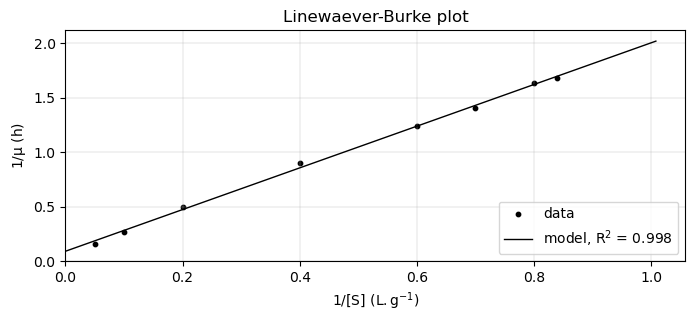

In [83]:
rS = D*(S0 - S) # Substrate consumption rate, g/L/h
rX = D*X # Growth rate, g/L/h

q = rS/X # Specific substrate consumption rate, 1/h

x = D.reshape((-1, 1))
y = q
model = LinearRegression().fit(x, y)
slope = model.coef_[0] # ==> 1/Y(X/S)
y_intercept = float(model.intercept_) # ==> m
R2 = model.score(x, y) # R^2

Y_XS = 1/slope # Yield on substrate, [-]
m = y_intercept # Maintenance energy, 1/h

print(f'Y(X/S) = {round(Y_XS, 2)}\nm = {round(m, 2)} h⁻¹\n')

# Create 2 points for plotting the model
x_model = np.array([0, D[-1]*1.2])
y_model = model.predict(x_model.reshape((-1, 1)))

plt.scatter(x, y, color = 'black', s = 10.0, label = 'data')
plt.plot(x_model, y_model, color = 'black', 
         label = r'model, $\mathregular{R^2}$ = ' + 
         f'{round(R2, 3):.3f}')
plt.xlabel(r'1/[S] ($\mathregular{L.g^{-1}}$)')
plt.ylabel(r'1/$\mathregular{\mu}$ (h)')
plt.xlim(0, np.max(x_model*1.05))
plt.ylim(0, np.max(y_model)*1.05)
plt.legend(loc = 'lower right')
plt.grid(linewidth = 0.25)
plt.title('Linewaever-Burke plot')
plt.show()
#plt.savefig('Projects\\2. Enzyme kinetics and microbial growth\\Images\\4.a.eps', format = 'eps')

**c) You will now examine the effect of the dilution rate on the system. Ignoring the maintenance energy, derive theoretical formulas for the maximum, $D_{max}$, and optimal, $D_{opt}$, values of the dilution rate and calculate them using the parameters found in part a).**

Hint: for $D_{max}$ : under which condition does dilution rate reach its maximum (See Slide 8 of Lecture 2 to remember)?


Hint: for $D_{opt}$: if cells are our product of interest, find the best operating condition that maximizes the productivity of the cells ($D[X]$).

From mass balance $\mu = D$ and from Monod kinetic $\mu = \mu_{max}\frac{[S]}{K_S + [S]}$, the maximal value of $D$ is:

* $D_{max} = \mu_{max} = D(\frac{K_S}{S} + 1)$.

If the dilution rate goes further, the cells are not able to multiply fast enough to compensate for the wash-out.

In [84]:
D_max = mu_max # Maximal dilution rate, 1/h

print(f'Dₘₐₓ = {round(D_max, 2)} h⁻¹')

Dₘₐₓ = 0.85 h⁻¹


The optimal dilution rate happens when the growth rate $r_X$ is at its maximum. Assuming this rate is always positive, then its maximum is found when:
 
* $\frac{d(r_X)}{dD} = 0$.

If the maintenance energy is not to be taken into account, then the growth rate is equal to the substrate consumption rate times the yield on substrate (assumed to be constant):

* $r_X = Y_{X/S}r_S$

From substrate mass balance, the substrate consumption rate can be written as:

* $r_S = D([S]_0 - [S])$

Which gives:

* $r_X = Y_{X/S}D([S]_0 - [S])$

Using Monod's equation and the fact that $\mu = D$, the substrate concentration can be written as:

* $[S] = \frac{DK_S}{D_{max} - D}$

The growth rate can finally be written as:

* $r_X = Y_{X/S}D([S]_0 - \frac{DK_S}{D_{max} - D})$

After derivation with respect to $D$:

* $Y_{X/S}([S]_0 - \frac{K_SD_{opt}}{D_{max} - D_{opt}}) + Y_{X/S}D_{opt}(-\frac{K_SD_{opt}}{(D_{max} - D_{opt})^2} - \frac{K_S}{D_{max} - D_{opt}})$

After isolating $D_{opt}$:

* $D_{opt} = \frac{{-\sqrt{{D_{max}^2K_{S}^2 + D_{max}^2K_{S}[S]_{0}}} + D_{max}(K_{S} + [S]_{0})}}{{K_{S} + [S]_{0}}}$

Note: second solution $D_{opt} = \frac{{\sqrt{{D_{max}^2K_{S}^2 + D_{max}^2K_{S}[S]_{0}}} + D_{max}(K_{S} + [S]_{0})}}{{K_{S} + [S]_{0}}}$ also exists but would find a minimum (the function found for $r_X$ isn't continuous).

In [85]:
D_opt = (-np.sqrt(D_max**2*Ks**2 + D_max**2*Ks*S0) + D_max*Ks + D_max*S0)/(Ks + S0)

print(f'Dₒₚₜ = {round(D_opt, 2)} h⁻¹')

Dₒₚₜ = 0.79 h⁻¹
